In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import joblib

# Load the dataset from the data folder
df = pd.read_csv('../data/creditcard.csv')

# Display the first 5 rows and the shape of the dataframe
print("First 5 rows of the dataset:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

In [8]:
# Scale 'Time' and 'Amount' features
scaler = StandardScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns as they are no longer needed
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Let's look at the first few rows of the modified dataframe
print("Dataframe after scaling Time and Amount:")
df.head()

Dataframe after scaling Time and Amount:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [9]:
# Define our features (X) and the target we want to predict (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (80% train, 20% test)
# We use 'stratify=y' to make sure both sets have a similar proportion of fraud cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- The most important step for imbalanced data! ---
# Calculate the scale_pos_weight value
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize and train the XGBoost model
# We tell it our objective is to predict a probability (binary:logistic)
# and we pass our calculated weight to handle the imbalance.
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

print("\nStarting model training...")
model.fit(X_train, y_train)
print("Model training complete.")

# Save the trained model to our 'src' folder
model_path = '../src/fraud_model.joblib'
joblib.dump(model, model_path)

print(f"\nModel successfully saved to: {model_path}")

Calculated scale_pos_weight: 577.29

Starting model training...


c:\Users\vasam\real-time-fraud-detection\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

Model successfully saved to: ../src/fraud_model.joblib


Making predictions on the test data...

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


--- Confusion Matrix ---


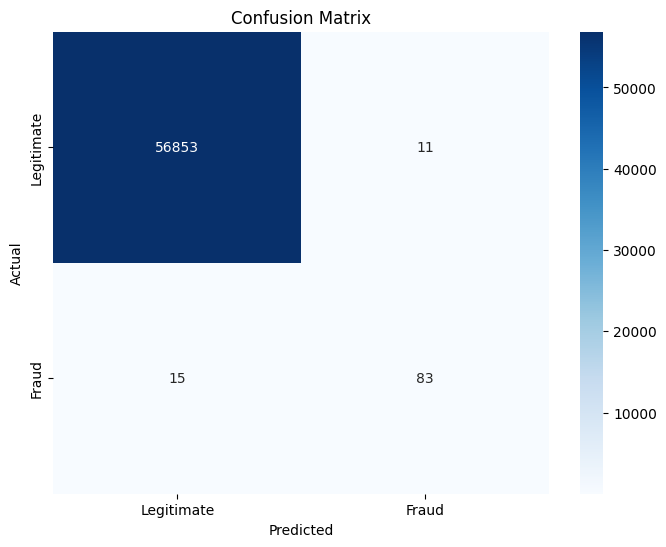

In [10]:
# --- Final Evaluation on the Unseen Test Data ---

# Make predictions on the test set
print("Making predictions on the test data...")
y_pred = model.predict(X_test)

# Print the detailed classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualize the results with a Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'], 
            yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()